In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.add("DifferentialEquations")
Pkg.add("Dierckx")
Pkg.instantiate()

  Activating environment at `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`
  No Changes to `~/all_about_robotics/julia_optimisation_course/tutorial/Manifest.toml`
   Resolving package versions...
  No Changes to `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`
  No Changes to `~/all_about_robotics/julia_optimisation_course/tutorial/Manifest.toml`


In [2]:
using ControlSystemsBase
using LinearAlgebra
using Plots
import ForwardDiff as FD
using DifferentialEquations
using Dierckx

In [3]:
# first link parameters
m1=1;  # in kg
l1=1; # in m

# second link parameters
m2=1;  # in kg
l2=1; # in m

# gravity 
g=9.81 #m/sec2


#mpc control parameters
ρ=10 # weigh on the position error
h=0.001 # horizon time of the prediction and euler step size




function dynamicParam(θ1,θ2,θ1_dot,θ2_dot)
    D1= ((m1+m2)*l1^2)+(m2*l2^2)+2*m2*l1*l2*cos(θ2)
    D2= (m2*l2^2)+(m2*l1*l2*cos(θ2))
    D3=D2
    D4=m2*l2^2
    
    # inertia matrix
    M=[D1 D2;D3 D4]
    #vector of gravity torques
    G=[-((m1+m2)*g*l1*sin(θ1))-(m2*g*l2*sin(θ1+θ2)) ; -m2*g*l2*sin(θ1+θ2)]
    #Coriolis centrifugal forces
    C=[-m2*l1*l2*(2*θ1_dot*θ2_dot+θ1_dot^2)*sin(θ2); -m2*l1*l2*θ1_dot*θ2_dot*sin(θ2)]
    
    return M,G,C
end


function actualDynamics(θ,τ)
    
    θ1,θ1_dot,θ2,θ2_dot=θ
    τ1,τ2=τ
    
    M,G,C=dynamicParam(θ1,θ2,θ1_dot,θ2_dot)
    
    x1=θ1_dot
    x3=θ2_dot
    x2,x4=M\(τ-G-C)
    
    return [x1,x2,x3,x4]
end

#use RK45 integrator with zero order hold control
function rk45step(θ,τ)
   f1=actualDynamics(θ,τ)
   f2=actualDynamics(θ+0.5*h*f1,τ)
   f3=actualDynamics(θ+0.5*h*f2,τ)
   f4=actualDynamics(θ+h*f3,τ)
    
   return θ+(h/6)*(f1+2*f2+2*f3+f4)   
end




rk45step (generic function with 1 method)

In [4]:
#simulate the free body dynamics of the system
function rk45_solve(t0, x0, tf)
    t = t0
    x = x0
        
    ts = [t] # vector to save time steps
    xs = [x0] # vector to save state trajectory
    τ=[0,0]
    
    while t < tf
        x_new = rk45step(x,τ)
        t += h
        x = x_new
        push!(ts, t)
        push!(xs, x)
    end
    
    return ts, xs
end


rk45_solve (generic function with 1 method)

In [5]:

x0=[0.001,0.0,0, 0.0]
# Time span
t0 = 0.0
tf = 10.0

t_vals, x_vals = rk45_solve(t0,x0,tf);


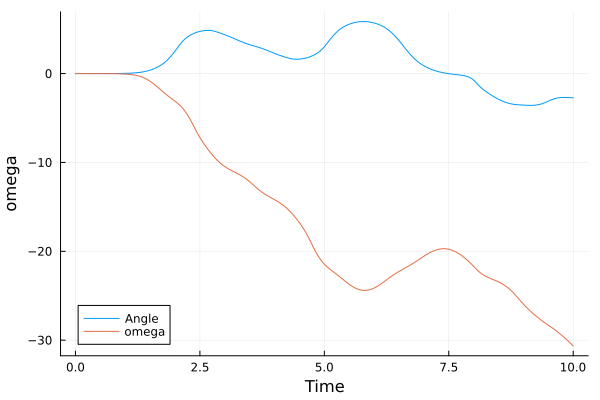

In [6]:
# Extract angle values
θ1_vals = [x[1] for x in x_vals]
w1_vals=[x[2] for x in x_vals]
θ2_vals = [x[3] for x in x_vals]
w2_vals=[x[4] for x in x_vals]

# Plot the results
plot(t_vals, θ1_vals, label="Angle", xlabel="Time", ylabel="Angle", legend=true)
plot!(t_vals, θ2_vals, label="omega", xlabel="Time", ylabel="omega", legend=true,show=true)

In [7]:
# Mapping from polar to Cartesian
x1 = l1*sin.(θ1_vals);          # First Pendulum
y1 = -l1*cos.(θ1_vals);

x2 = x1 + l2*sin.(θ2_vals);     # Second Pendulum
y2 = y1 - l2*cos.(θ2_vals);

In [28]:
sp_x1 = Spline1D(t_vals, x1);
sp_y1 = Spline1D(t_vals, y1);
sp_x2 = Spline1D(t_vals, x2);
sp_y2 = Spline1D(t_vals, y2);

In [29]:
# Interpolated variables
x1_u = sp_x1(t_u);
y1_u = sp_y1(t_u);
x2_u = sp_x2(t_u);
y2_u = sp_y2(t_u);

In [30]:
dt = 0.05;
t_u = 0:dt:tf;

In [31]:
# Interpolated variables
x1_u = sp_x1(t_u);
y1_u = sp_y1(t_u);
x2_u = sp_x2(t_u);
y2_u = sp_y2(t_u);

In [34]:
# Animation setup
# Refs.
# 1. http://docs.juliaplots.org/latest/attributes/
# 2. http://docs.juliaplots.org/latest/animations/

L = l1 + l2;
axis_lim = L*1.2;   # defining the limits of the axes



anim = Animation()
#p = plot([sin,cos], 0, π, size=(200,200))

for i =1:length(t_u)
    
    str = string("Time = ", round(t_vals[i],1), " sec");
    
    plot([0,x1_u[i]], [0,y1_u[i]],size=(400,300),xlim=(-axis_lim,axis_lim),ylim=(-axis_lim,1),markersize = 10, markershape = :circle,label ="",axis = []);
    plot!([x1_u[i],x2_u[i]], [y1_u[i],y2_u[i]],markersize = 10, markershape = :circle,label ="",title = str, title_location = :left, aspect_ratio = :equal);
    
    if i > 9
        plot!([x2_u[i-3:i]], [y2_u[i-3:i]],alpha = 0.15,linewidth = 2, color = :red,label ="");
        plot!([x2_u[i-5:i-3]], [y2_u[i-5:i-3]],alpha = 0.08,linewidth = 2, color = :red,label ="");
        plot!([x2_u[i-7:i-5]], [y2_u[i-7:i-5]],alpha = 0.04,linewidth = 2, color = :red, label ="");
        plot!([x2_u[i-9:i-7]], [y2_u[i-9:i-7]],alpha = 0.01,linewidth = 2, color = :red, label="");
        
        
    end
    
    
    
    
    frame(anim)
end


LoadError: MethodError: no method matching round(::Float64, ::Int64)
[0mClosest candidates are:
[0m  round(::T, [91m::RoundingMode{:NearestTiesUp}[39m) where T<:AbstractFloat at floatfuncs.jl:219
[0m  round([91m::Type{T}[39m, ::Integer) where T<:Integer at int.jl:594
[0m  round([91m::Type{T}[39m, ::Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit}) where T<:VectorizationBase.AbstractSIMD at /home/ram/.julia/packages/VectorizationBase/0dXyA/src/base_defs.jl:199
[0m  ...

In [13]:

gif(anim,fps = 30)


LoadError: UndefVarError: anim not defined

In [14]:
k1=2/(h^2+4*ρ)
k2=(2*h^2+4*ρ)/(h^3+4*ρ*h)

1000.0000249999994